# A New Approach to Coordinate Systems
Make heavy use of coordinate formalism rather than the small angle assumption everywhere

In [85]:
import numpy as np
import scipy.interpolate
import matplotlib.pyplot as plt
import astropy.units as u
import yt
import solarbextrapolation.extrapolators
import sunpy.map
import sunpy.coordinates
from astropy.coordinates import SkyCoord

import synthesizAR.extrapolate
import synthesizAR.util

import pdb

%matplotlib inline

First, extrapolate a potential field using the old method.

In [2]:
hmi = sunpy.map.Map('/Users/willbarnes/sunpy/data/hmi_m_45s_2010_09_29_23_52_30_tai_magnetogram.fits').rotate()
width = 300*u.arcsec
height = 300*u.arcsec
lc = SkyCoord(361.5*u.arcsec-width/2, 261.5*u.arcsec-height/2,frame=hmi.coordinate_frame)
rc = SkyCoord(361.5*u.arcsec+width/2, 261.5*u.arcsec+height/2,frame=hmi.coordinate_frame)
hmi_zoom = hmi.submap(lc,rc)

/Users/willbarnes/anaconda/envs/synthesizar_coords/lib/python3.6/site-packages/sunpy/image/transform.py:128: RuntimeWarning: Setting NaNs to 0 for higher-order scikit-image rotation
  RuntimeWarning)


/Users/willbarnes/anaconda/envs/synthesizar_coords/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


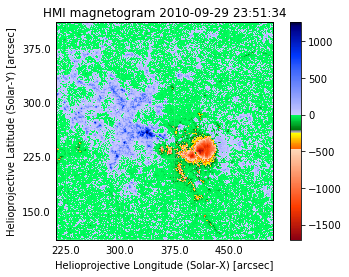

In [3]:
hmi_zoom.peek(cmap='hmimag')

In [4]:
hmi_zoom_resampled = hmi_zoom.resample([100,100]*u.pixel)

In [5]:
extrapolator = solarbextrapolation.extrapolators.PotentialExtrapolator(hmi_zoom_resampled,
                                                                       zshape=100,
                                                                       zrange=[0,300]*u.arcsec)

/Users/willbarnes/anaconda/envs/synthesizar_coords/lib/python3.6/site-packages/solarbextrapolation/extrapolators/base.py:81: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  self.xrange = self.map_boundary_data.xrange.to(map_magnetogram.meta['cunit1'])
/Users/willbarnes/anaconda/envs/synthesizar_coords/lib/python3.6/site-packages/solarbextrapolation/extrapolators/base.py:82: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  self.yrange = self.map_boundary_data.yrange.to(map_magnetogram.meta['cunit2'])
/Users/willbarnes/anaconda/envs/synthesizar_coords/lib/python3.6/site-packages/solarbextrapolation/extrapolators/base.py:83: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  self.xobsrange = self.map_boundary_data.xrange.to(map_magnetogram.meta['cunit1'])
/Users/willbarnes/anaconda/envs/synthesizar_coords/lib/python3.6/site-packages/solarbextrapolation/extrapolators/base.py:84: SunpyDeprecationWarning: This prope

In [6]:
b_field = extrapolator.extrapolate(enable_numba=True)

True


Build yt dataset from the magnetic field. Still not entirely sure how to calculate widths

In [111]:
left_corner = synthesizAR.extrapolate.heeq_to_local(
    *u.Quantity(synthesizAR.util.to_heeq(hmi_zoom.bottom_left_coord))[:,np.newaxis],hmi_zoom.center)
right_corner = synthesizAR.extrapolate.heeq_to_local(
    *u.Quantity(synthesizAR.util.to_heeq(hmi_zoom.top_right_coord))[:,np.newaxis],hmi_zoom.center)
width_x = (right_corner[0] - left_corner[0])[0]
width_y = (right_corner[1] - left_corner[1])[0]
#width_x = np.diff(b_field.xrange)[0].to(u.radian).value * (hmi_zoom.meta['dsun_ref']*u.m - sunpy.sun.constants.radius)
#width_y = np.diff(b_field.yrange)[0].to(u.radian).value * (hmi_zoom.meta['dsun_ref']*u.m - sunpy.sun.constants.radius)
width_z = np.diff(b_field.zrange)[0].to(u.radian).value * (hmi_zoom.meta['dsun_ref']*u.m - sunpy.sun.constants.radius)
b_field_data = (b_field.data*u.T).to(u.Gauss)
for i in range(3):
    for j in [0,1]:
        b_field_data[j,:,:,i] = b_field_data[2,:,:,i]
        b_field_data[:,j,:,i] = b_field_data[:,2,:,i]
        b_field_data[:,:,j,i] = b_field_data[:,:,2,i]
    for j in [-2,-1]:
        b_field_data[j,:,:,i] = b_field_data[-3,:,:,i]
        b_field_data[:,j,:,i] = b_field_data[:,-3,:,i]
        b_field_data[:,:,j,i] = b_field_data[:,:,-3,i]
b_field_ds = synthesizAR.extrapolate.magnetic_field_to_yt_dataset(b_field_data[:,:,:,1],
                                                                  b_field_data[:,:,:,0],
                                                                  b_field_data[:,:,:,2],width_x,width_y,width_z)

yt : [INFO     ] 2018-02-03 19:03:03,163 Parameters: current_time              = 0.0
yt : [INFO     ] 2018-02-03 19:03:03,164 Parameters: domain_dimensions         = [100 100 100]
yt : [INFO     ] 2018-02-03 19:03:03,165 Parameters: domain_left_edge          = [ -1.37954338e+10  -1.07028664e+10   0.00000000e+00]
yt : [INFO     ] 2018-02-03 19:03:03,167 Parameters: domain_right_edge         = [  1.37954338e+10   1.07028664e+10   2.16569708e+10]
yt : [INFO     ] 2018-02-03 19:03:03,169 Parameters: cosmological_simulation   = 0.0


In [113]:
width_x.to(u.Mm)

<Quantity 275.9086751354809 Mm>

In [115]:
sunpy.sun.constants.radius.to(u.Mm)

<Quantity 695.5079999999999 Mm>

In [34]:
seeds = u.Quantity(synthesizAR.extrapolate.find_seed_points(b_field_ds,hmi_zoom_resampled,100),'cm')
seeds_x_hcc,seeds_y_hcc,seeds_z_hcc = synthesizAR.util.heeq_to_hcc(
    *synthesizAR.extrapolate.local_to_heeq(seeds[:,0],seeds[:,1],seeds[:,2],hmi_zoom_resampled.center),
    hmi_zoom_resampled.observer_coordinate
)

In [35]:
#%debug
fieldlines= synthesizAR.extrapolate.trace_fieldlines(b_field_ds,hmi_zoom_resampled,500,max_tries=100)

yt : [INFO     ] 2018-02-03 15:32:47,998 AMRKDTree rebuilt, Final Volume: 1.279067e+31
Streamlining: 100%|██████████| 500/500 [00:01<00:00, 477.72it/s]
yt : [INFO     ] 2018-02-03 15:32:49,753 AMRKDTree rebuilt, Final Volume: 1.279067e+31
Streamlining: 100%|██████████| 158/158 [00:00<00:00, 368.44it/s]
yt : [INFO     ] 2018-02-03 15:32:50,559 AMRKDTree rebuilt, Final Volume: 1.279067e+31
Streamlining: 100%|██████████| 49/49 [00:00<00:00, 406.53it/s]
yt : [INFO     ] 2018-02-03 15:32:50,958 AMRKDTree rebuilt, Final Volume: 1.279067e+31
Streamlining: 100%|██████████| 14/14 [00:00<00:00, 388.34it/s]
yt : [INFO     ] 2018-02-03 15:32:51,251 AMRKDTree rebuilt, Final Volume: 1.279067e+31
Streamlining: 100%|██████████| 4/4 [00:00<00:00, 111.44it/s]
yt : [INFO     ] 2018-02-03 15:32:51,569 AMRKDTree rebuilt, Final Volume: 1.279067e+31
Streamlining: 100%|██████████| 2/2 [00:00<00:00, 108.61it/s]


In [36]:
s_x,s_y = width_x.to(u.cm).value/2,width_y.to(u.cm).value/2
axis_0 = u.Quantity([[-s_x,-s_y,0],
                     [-s_x,s_y,0]],u.cm)
axis_1 = u.Quantity([[-s_x,s_y,0],
                     [s_x,s_y,0]],u.cm)
axis_2 = u.Quantity([[s_x,s_y,0],
                     [s_x,-s_y,0]],u.cm)
axis_3 = u.Quantity([[s_x,-s_y,0],
                     [-s_x,-s_y,0]],u.cm)
norm = u.Quantity([[0,0,0],[0,0,0.1*sunpy.sun.constants.radius.to(u.cm).value]],u.cm)

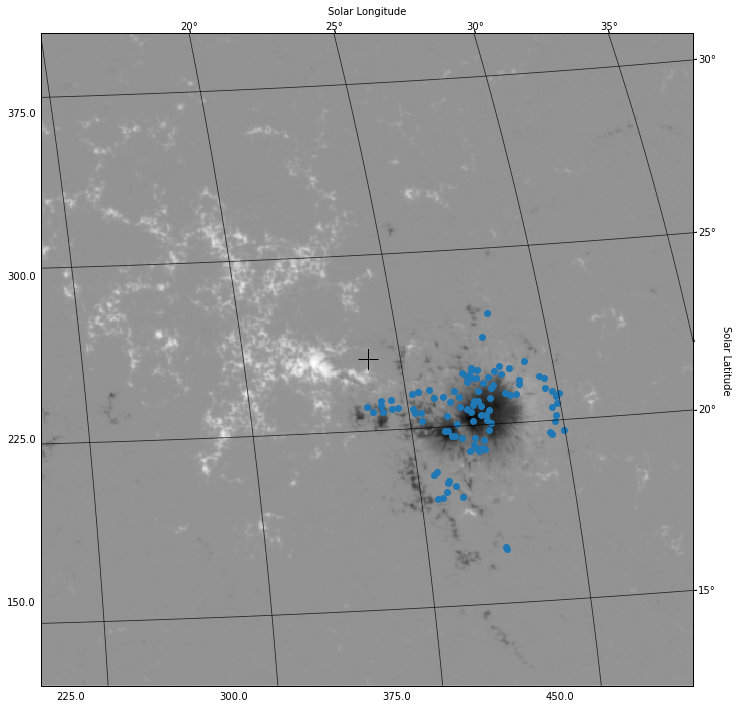

In [39]:
fig = plt.figure(figsize=(12,12))
ax = fig.gca(projection=hmi_zoom)
hmi_zoom.rotate(0*u.deg,missing=np.nan,recenter=False).plot(title=False,annotate=False)
ax.grid(alpha=0)
hmi_zoom.draw_grid(axes=ax,grid_spacing=5*u.deg,color='k',alpha=0.75)
ax.plot_coord(hmi_zoom.center,marker='+',markersize=20,color='k')
# draw corners
#left_corner_hcc = synthesizAR.util.heeq_to_hcc(
#    *synthesizAR.extrapolate.local_to_heeq(*(u.Quantity([b_field_ds.domain_left_edge],'cm')).T,
#                                           hmi_zoom.center),
#    hmi_zoom.observer_coordinate
#)
#right_corner_hcc = synthesizAR.util.heeq_to_hcc(
#    *synthesizAR.extrapolate.local_to_heeq(*(u.Quantity([[b_field_ds.domain_right_edge[0],
#                                                         b_field_ds.domain_right_edge[1],
#                                                         b_field_ds.domain_left_edge[2]]],'cm')).T,
#                                           hmi_zoom.center),
#    hmi_zoom_resampled.observer_coordinate
#)
#ax.plot_coord(SkyCoord(x=left_corner_hcc[0],y=left_corner_hcc[1],z=left_corner_hcc[2],
#                       frame=sunpy.coordinates.frames.Heliocentric,
#                       observer=hmi_zoom.observer_coordinate).transform_to(hmi_zoom.coordinate_frame),
#              marker='+',color='C0',markersize=10)
#ax.plot_coord(SkyCoord(x=right_corner_hcc[0],y=right_corner_hcc[1],z=right_corner_hcc[2],
#                       frame=sunpy.coordinates.frames.Heliocentric,
#                       observer=hmi_zoom.observer_coordinate).transform_to(hmi_zoom.coordinate_frame),
#              marker='+',color='C1',markersize=10)
# plot axes
#for i,cax in enumerate([axis_0,axis_1,axis_2,axis_3,norm]):
#    x_hcc,y_hcc,z_hcc = synthesizAR.util.heeq_to_hcc(
#        *synthesizAR.extrapolate.local_to_heeq(cax[:,0],cax[:,1],cax[:,2],hmi_zoom.center),
#        hmi_zoom.observer_coordinate
#    )
#    ax.plot_coord(SkyCoord(x_hcc,y_hcc,z_hcc,
#                           frame=sunpy.coordinates.frames.Heliocentric,
#                           observer=hmi_zoom.observer_coordinate
#                          ).transform_to(hmi_zoom.coordinate_frame),
#                  '-',lw=4,color=f'C{0 if i < 4 else 1}')
# plot seed points
for line,mag in fieldlines[::5]:
    line = u.Quantity(line,u.cm)
    x_hcc,y_hcc,z_hcc = synthesizAR.util.heeq_to_hcc(
        *synthesizAR.extrapolate.local_to_heeq(line[:,0],line[:,1],line[:,2],hmi_zoom.center),
        hmi_zoom.observer_coordinate
    )
    ax.plot_coord(SkyCoord(x_hcc[0],y_hcc[0],z_hcc[0],
                           frame=sunpy.coordinates.frames.Heliocentric,
                           observer=hmi_zoom.observer_coordinate
                          ).transform_to(hmi_zoom.coordinate_frame),
                  'o',lw=1,color=f'C0')
#for i in range(100):
#    ax.plot_coord(SkyCoord(seeds_x_hcc[i],seeds_y_hcc[i],seeds_z_hcc[i],
#                           frame=sunpy.coordinates.frames.Heliocentric,
#                           observer=hmi_zoom.observer_coordinate
#                          ).transform_to(hmi_zoom.coordinate_frame),
#                  markersize=5,marker='o',color='C2',alpha=0.75)

In [40]:
hmi_zoom.meta

MetaDict([('xtension', 'IMAGE'),
          ('bitpix', 32),
          ('naxis', 2),
          ('naxis1', 595),
          ('naxis2', 595),
          ('pcount', 0),
          ('gcount', 1),
          ('date', '2012-09-05T07:58:59'),
          ('date-obs', '2010-09-29T23:51:34.30'),
          ('telescop', 'SDO/HMI'),
          ('instrume', 'HMI_FRONT2'),
          ('wavelnth', 6173.0),
          ('camera', 2),
          ('bunit', 'Gauss'),
          ('origin', 'SDO/JSOC-SDP'),
          ('content', 'MAGNETOGRAM'),
          ('quality', 0),
          ('quallev1', 0),
          ('history',
           'Polynomial Coefficients used for Doppler velocity correction: 1.801953e+02 1.419588e-03 -5.573298e-07 2.395759e-10CROTA2 corrected by adding -0.0702 degrees'),
          ('comment',
           'De-rotation: ON; Un-distortion: ON; Re-centering: ON; Re-sizing: OFF; RSUNerr=0.5; correction for cosmic-ray hits'),
          ('bld_vers', '-511'),
          ('hcamid', 3),
          ('source',
        

## Reprojection Sandbox

In [61]:
hmi_zoom_resampled.pixel_to_world([0,1]*u.pixel,[90,2]*u.pixel)

<SkyCoord (Helioprojective: obstime=2010-09-29 23:51:34.300000, rsun=696000000.0 m, observer=<HeliographicStonyhurst Coordinate (obstime=2010-09-29 23:51:34.300000): (lon, lat, radius) in (deg, deg, m)
    ( 0.,  6.786839,   1.49827435e+11)>): (Tx, Ty) in arcsec
    [( 213.19783318,  383.34721663), ( 216.19834241,  119.32359384)]>

/Users/willbarnes/anaconda/envs/synthesizar_coords/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


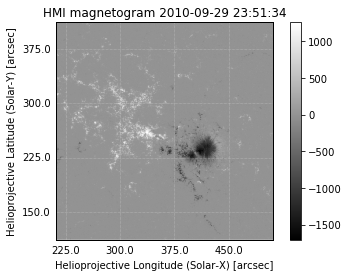

In [44]:
hmi_zoom.peek()

In [109]:
pixel_grids = np.indices((int(hmi_zoom_resampled.dimensions.x.value),
                                        int(hmi_zoom_resampled.dimensions.y.value)))

In [58]:
pixel_pairs = u.Quantity([(i_x,i_y) for i_x,i_y in zip(pixel_grid_x.flatten(),pixel_grid_y.flatten())],'pixel')

In [62]:
pixel_pairs.shape

(10000, 2)

In [67]:
coords = hmi_zoom_resampled.pixel_to_world(pixel_pairs[:,0],pixel_pairs[:,1])

In [69]:
local_coords = synthesizAR.extrapolate.heeq_to_local(
    *u.Quantity(synthesizAR.util.to_heeq(coords)),hmi_zoom_resampled.center)

In [94]:
coord_points = np.stack([local_coords[0].value,local_coords[1].value],axis=1)
hmi_data = hmi_zoom_resampled.data.flatten()

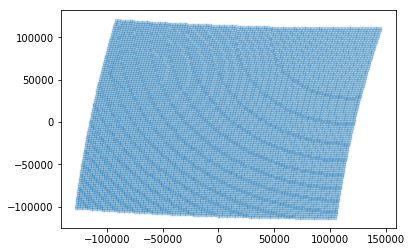

In [79]:
plt.plot(local_coords[0].value,local_coords[1].value,'.',alpha=0.25)

In [96]:
x_new = np.linspace(-width_x/2,width_x/2,100)
y_new = np.linspace(-width_y/2,width_y/2,100)
x_grid,y_grid = np.meshgrid(x_new,y_new)

In [102]:
hmi_map_interp = scipy.interpolate.griddata(coord_points,hmi_data,(x_grid,y_grid),fill_value=0.)

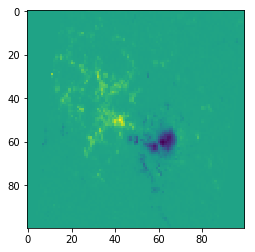

In [103]:
plt.imshow(np.flipud(hmi_map_interp))

In [106]:
foo_map = sunpy.map.Map(hmi_map_interp,hmi_zoom_resampled.meta)

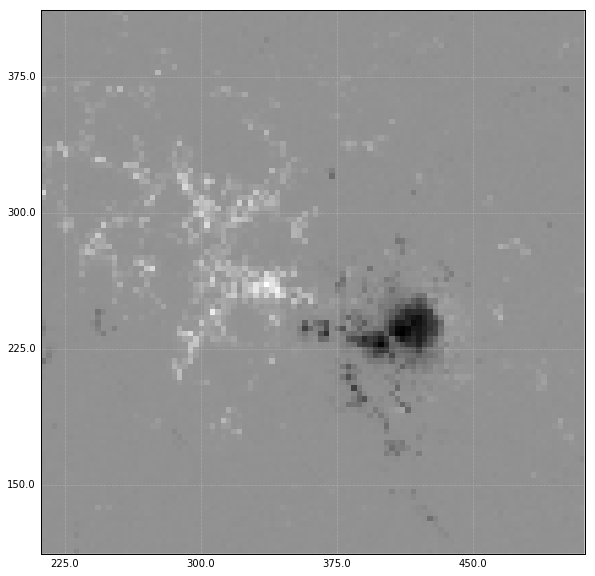

In [108]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection=hmi_zoom_resampled)
hmi_zoom_resampled.plot(annotate=False,title=False)

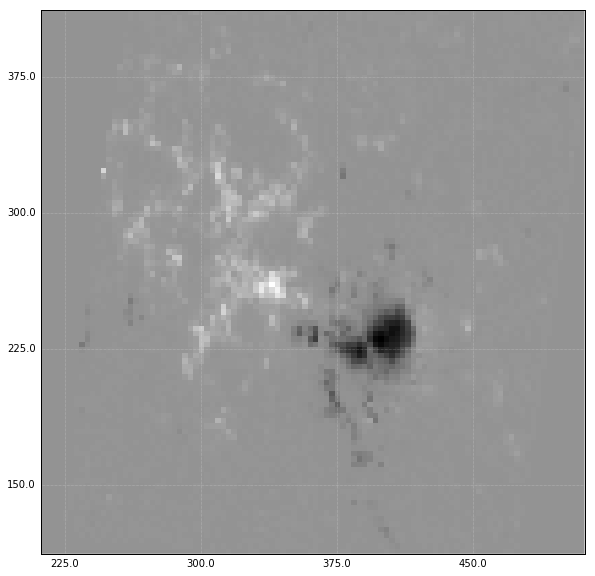

In [107]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection=foo_map)
foo_map.plot(annotate=False,title=False)

## Sandbox

In [ ]:
# Better way
left_corner = hmi_zoom.bottom_left_coord.transform_to('heliocentric', hmi_zoom.observer_coordinate)
right_corner = hmi_zoom.top_right_coord.transform_to('heliocentric', hmi_zoom.observer_coordinate)
#width_z = max(width_x,width_y)
###
#width_x = (#(np.diff(b_field.xrange)[0]).to(u.radian).value 
#           #* (hmi_zoom.meta['dsun_ref']*u.m - sunpy.sun.constants.radius)
#           width_x / np.cos(hmi_zoom.center.transform_to('heliographic_stonyhurst').lon.to(u.radian))
#          )
#width_y = (#(np.diff(b_field.yrange)[0]).to(u.radian).value 
#           #* (hmi_zoom.meta['dsun_ref']*u.m - sunpy.sun.constants.radius)
#           width_y / np.cos(hmi_zoom.center.transform_to('heliographic_stonyhurst').lat.to(u.radian))
#          )
width_z = (300*u.arcsec).to(u.radian).value * (hmi_zoom.meta['dsun_ref']*u.m - sunpy.sun.constants.radius)
#x,y,z = synthesizAR.util.to_heeq(hmi_zoom.top_right_coord)
#x_rc, y_rc, z_rc = synthesizAR.extrapolate.heeq_to_local(u.Quantity([x]),u.Quantity([y]),u.Quantity([z]),
#                                                         hmi_zoom.center)
#x,y,z = synthesizAR.util.to_heeq(hmi_zoom.bottom_left_coord)
#x_lc, y_lc, z_lc = synthesizAR.extrapolate.heeq_to_local(u.Quantity([x]),u.Quantity([y]),u.Quantity([z]),
#                                                         hmi_zoom.center)
#width_x = (x_rc - x_lc)[0] / np.cos(hmi_zoom.center.transform_to('heliographic_stonyhurst').lon.to(u.radian))
#width_y = (y_rc - y_lc)[0] / np.cos(hmi_zoom.center.transform_to('heliographic_stonyhurst').lat.to(u.radian))
#width_z = (z_rc - z_lc)[0]
#width_x = np.sqrt((right_corner.x - left_corner.x)**2 + (right_corner.z - left_corner.z)**2)
#width_y = np.sqrt((right_corner.y - left_corner.y)**2 + (right_corner.z - left_corner.z)**2)

In [ ]:
test_map = hmi_zoom_resampled
fig = plt.figure(figsize=(12,12))
ax = fig.gca(projection=test_map)
test_map.plot(title=False)
ax.grid(alpha=0.5,color='k')
test_map.draw_grid(axes=ax,grid_spacing=5*u.deg,color='k',alpha=0.75)
# Expand the view a bit
ax.plot_coord(SkyCoord(Tx=200*u.arcsec,Ty=90*u.arcsec,frame='helioprojective',
                       observer=hmi_zoom.observer_coordinate),'ow')
ax.plot_coord(SkyCoord(Tx=520*u.arcsec,Ty=420*u.arcsec,frame='helioprojective',
                       observer=hmi_zoom.observer_coordinate),'ow')
# Draw corners of the rotated frame
left_corner_hcc = synthesizAR.util.heeq_to_hcc(
    *synthesizAR.extrapolate.local_to_heeq(*(u.Quantity([b_field_ds.domain_left_edge],'cm')).T,
                                           hmi_zoom_resampled.center),
    hmi_zoom_resampled.observer_coordinate
)
right_corner_hcc = synthesizAR.util.heeq_to_hcc(
    *synthesizAR.extrapolate.local_to_heeq(*(u.Quantity([[b_field_ds.domain_right_edge[0],
                                                         b_field_ds.domain_right_edge[1],
                                                         b_field_ds.domain_left_edge[2]]],'cm')).T,
                                           hmi_zoom_resampled.center),
    hmi_zoom_resampled.observer_coordinate
)
ax.plot_coord(SkyCoord(x=left_corner_hcc[0],y=left_corner_hcc[1],z=left_corner_hcc[2],
                       frame=sunpy.coordinates.frames.Heliocentric,
                       observer=test_map.observer_coordinate).transform_to(test_map.coordinate_frame),
              marker='+',color='C0',markersize=10)
ax.plot_coord(SkyCoord(x=right_corner_hcc[0],y=right_corner_hcc[1],z=right_corner_hcc[2],
                       frame=sunpy.coordinates.frames.Heliocentric,
                       observer=test_map.observer_coordinate).transform_to(test_map.coordinate_frame),
              marker='+',color='C1',markersize=10)
#for i in range(100):
#    ax.plot_coord(SkyCoord(seeds_x_hcc[i],seeds_y_hcc[i],seeds_z_hcc[i],
#                           frame=sunpy.coordinates.frames.Heliocentric,
#                           observer=test_map.observer_coordinate
#                          ).transform_to(test_map.coordinate_frame),
#                  markersize=5,marker='o',color='C0',alpha=0.75)

In [ ]:
x,y,z = synthesizAR.util.to_heeq(hmi_zoom.top_right_coord)
x_rc, y_rc, z_rc = synthesizAR.extrapolate.heeq_to_local(u.Quantity([x]),u.Quantity([y]),u.Quantity([z]),
                                                         hmi_zoom.center)
x,y,z = synthesizAR.util.to_heeq(hmi_zoom.bottom_left_coord)
x_lc, y_lc, z_lc = synthesizAR.extrapolate.heeq_to_local(u.Quantity([x]),u.Quantity([y]),u.Quantity([z]),
                                                         hmi_zoom.center)

In [ ]:
(x_rc - x_lc)/width_x

In [ ]:
# Make map from yt data
b_slice = b_field_ds.slice('z',b_field_ds.domain_left_edge[2],)
b_slice.get_data('Bz')
yt_map = sunpy.map.Map(np.transpose(np.array(b_slice.field_data[('stream','Bz')]).reshape((100,100))),
                       hmi_zoom_resampled.meta)
yt_map.peek()

In [ ]:
a = 1

In [ ]:
def foo(**kwargs):
    print(kwargs.keys())

In [ ]:
foo(a=1,b=2,c=3)

In [ ]:
foo = {'a':1,'b':2,'c':3}

In [ ]:
list(foo.keys())

In [110]:
np.linspace(-1*u.cm,1*u.cm)

<Quantity [-1.        ,-0.95918367,-0.91836735,-0.87755102,-0.83673469,
           -0.79591837,-0.75510204,-0.71428571,-0.67346939,-0.63265306,
           -0.59183673,-0.55102041,-0.51020408,-0.46938776,-0.42857143,
           -0.3877551 ,-0.34693878,-0.30612245,-0.26530612,-0.2244898 ,
           -0.18367347,-0.14285714,-0.10204082,-0.06122449,-0.02040816,
            0.02040816, 0.06122449, 0.10204082, 0.14285714, 0.18367347,
            0.2244898 , 0.26530612, 0.30612245, 0.34693878, 0.3877551 ,
            0.42857143, 0.46938776, 0.51020408, 0.55102041, 0.59183673,
            0.63265306, 0.67346939, 0.71428571, 0.75510204, 0.79591837,
            0.83673469, 0.87755102, 0.91836735, 0.95918367, 1.        ] cm>